**Mood Ring AI: Emotional State Prediction from Online Message**

**1. Import Necessary Libraries**

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Text processing
import re
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /Users/hienvo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/hienvo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hienvo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**2. Load and Preprocess the Data**

In [2]:
# Load the dataset
data = pd.read_csv('Combined Data.csv')
data = data.dropna(subset=['statement'])
data = data.reset_index(drop=True)

**3. Visualize Class Distribution**

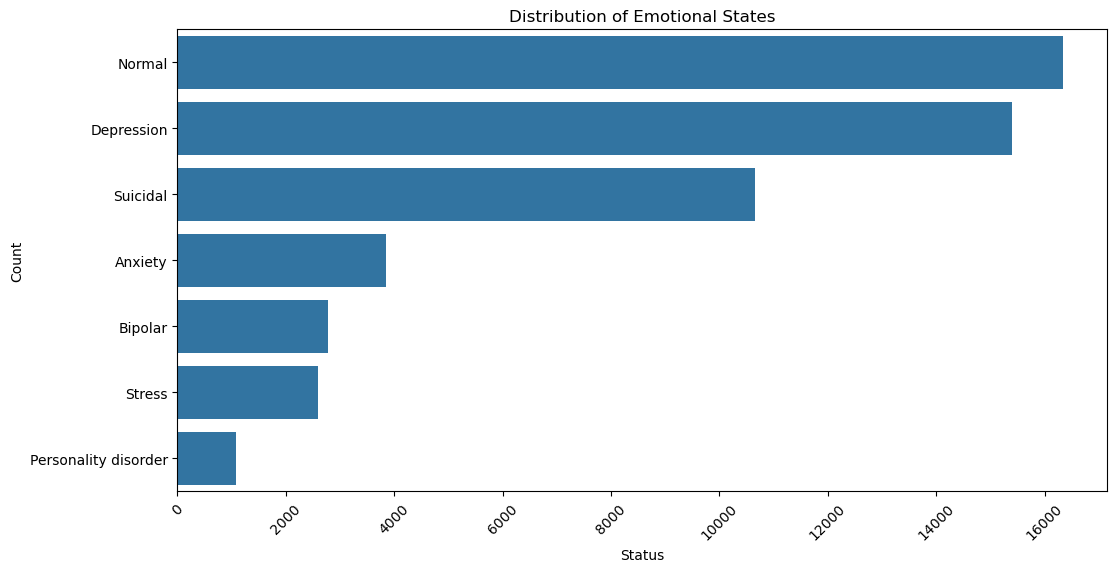

In [3]:
# Visualize the distribution of emotional states
plt.figure(figsize=(12, 6))
sns.countplot(data['status'], order=data['status'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Emotional States')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

**4. Enhanced Text Preprocessing**

*4.1. Define Preprocessing Functions*

In [4]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Load NLTK stop words and add custom stop words
stop_words = set(stopwords.words('english'))
custom_stop_words = {'u', 'im', 'ur', 'dont', 'cant'}  # Add custom stop words
stop_words = stop_words.union(custom_stop_words)

# Slang and abbreviation dictionary
slang_dict = {
    "u": "you",
    "im": "I am",
    "ur": "your",
    "dont": "do not",
    "cant": "cannot",
    # Add more slang and abbreviations as needed
}

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Replace slang and abbreviations
    for slang, full_form in slang_dict.items():
        text = re.sub(r'\b{}\b'.format(slang), full_form, text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a string
    text = ' '.join(tokens)
    
    return text

*4.2. Apply Preprocessing*

In [5]:
# Apply preprocessing to the 'statement' column
data['cleaned_statement'] = data['statement'].apply(preprocess_text)

**5. Data Augmentation for Minority Classes**

In [6]:
# Identify minority classes (classes with counts below a certain threshold)
class_counts = data['status'].value_counts()
threshold = 100  # Adjust this threshold based on your dataset
minority_classes = class_counts[class_counts < threshold].index.tolist()

# Define a function to perform synonym replacement for data augmentation
def augment_text(text):
    words = text.split()
    new_words = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            # Replace the word with its synonym
            synonym = synonyms[0].lemmas()[0].name()
            new_words.append(synonym)
        else:
            new_words.append(word)
    return ' '.join(new_words)

# Augment data for minority classes
augmented_data = data[data['status'].isin(minority_classes)].copy()
augmented_data['cleaned_statement'] = augmented_data['cleaned_statement'].apply(augment_text)

# Combine the original and augmented data
data = pd.concat([data, augmented_data], ignore_index=True)

**6. Prepare Features and Labels**

In [7]:
# Extract features and labels
X = data['cleaned_statement']
y = data['status']

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

**7. Text Vectorization using TF-IDF**

In [8]:
# Initialize the TF-IDF Vectorizer with expanded n-grams
tfidf = TfidfVectorizer(
    lowercase=True,
    max_features=5000,
    ngram_range=(1, 3)  # Include unigrams, bigrams, and trigrams
)

# Fit and transform the cleaned statements
X_tfidf = tfidf.fit_transform(X)

**8. Split Data into Training and Test Sets**

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

**9. Handle Class Imbalance with SMOTE**

In [10]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

**10. Adjust Class Weights**

In [11]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
class_weight_dict = dict(zip(np.unique(y_train_resampled), class_weights))

**11. Build and Train a Logistic Regression Model**

*11.1. Initialize the Model*

In [12]:
# Initialize the Logistic Regression model with class weights
model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

*11.2. Hyperparameter Tuning with Grid Search*

In [13]:
# Define parameter grid for Grid Search
param_grid = {
    'C': [0.1, 1, 10],             # Regularization strength
    'solver': ['liblinear', 'lbfgs']  # Optimization algorithms
}

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

# Perform Grid Search on resampled data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best estimator
best_model = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'C': 10, 'solver': 'lbfgs'}


*11.3. Train the Best Model*

In [14]:
# Train the best model on the resampled data
best_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42)

**12. Evaluate the Model**

*12.1. Performance on Test Set*

In [15]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

*12.2. Classification Report*

In [16]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.66      0.76      0.71       768
             Bipolar       0.79      0.77      0.78       556
          Depression       0.72      0.64      0.68      3081
              Normal       0.89      0.81      0.85      3269
Personality disorder       0.60      0.65      0.62       215
              Stress       0.44      0.62      0.51       517
            Suicidal       0.58      0.66      0.62      2131

            accuracy                           0.71     10537
           macro avg       0.67      0.70      0.68     10537
        weighted avg       0.73      0.71      0.72     10537



*12.3. Confusion Matrix*

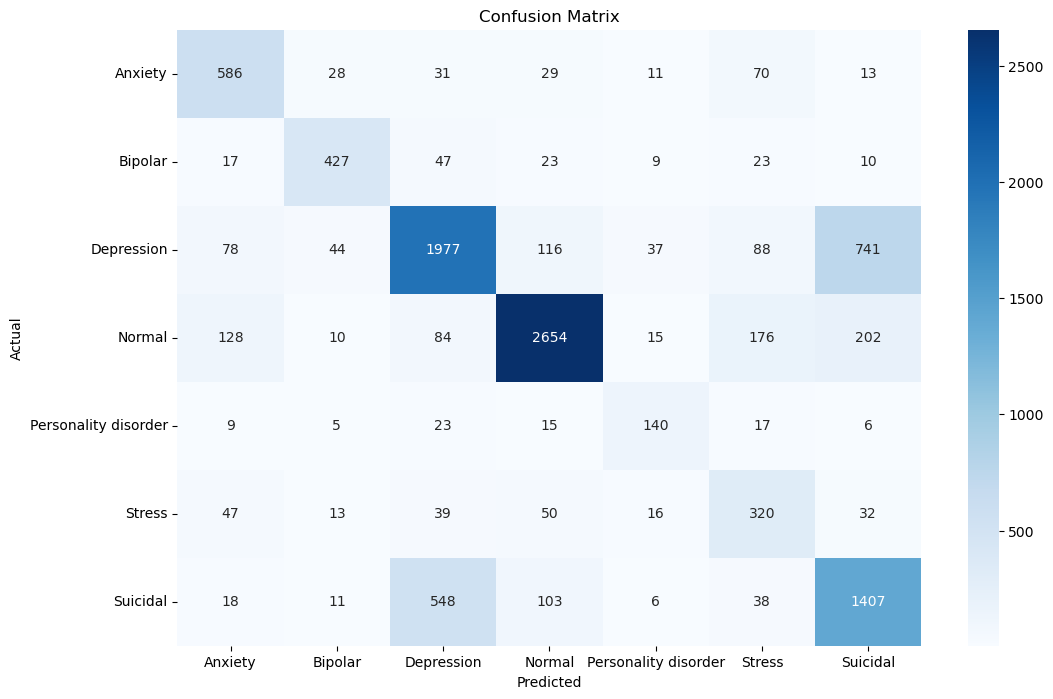

In [17]:
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cmap='Blues'
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**13. Visualization Enhancements**

*13.1. Feature Importance Visualization*

In [18]:
# Get feature names
feature_names = tfidf.get_feature_names_out()

# Get coefficients from the model
coefficients = best_model.coef_

# For each class, get the top features
num_classes = len(label_encoder.classes_)
num_top_features = 10  # Number of top features to display

for i in range(num_classes):
    # Get the coefficients for the class
    coef = coefficients[i]
    # Get the top positive and negative coefficients
    top_positive_indices = np.argsort(coef)[-num_top_features:]
    top_negative_indices = np.argsort(coef)[:num_top_features]
    
    top_positive_features = [feature_names[j] for j in top_positive_indices]
    top_negative_features = [feature_names[j] for j in top_negative_indices]
    
    print(f"\nClass: {label_encoder.classes_[i]}")
    print(f"Top Positive Features: {top_positive_features}")
    print(f"Top Negative Features: {top_negative_features}")


Class: Anxiety
Top Positive Features: ['find hard', 'googling', 'rabies', 'worried', 'health anxiety', 'nervous', 'ampxb', 'anxious', 'anxiety', 'restless']
Top Negative Features: ['wa', 'doe', 'bipolar', 'suicidal', 'view', 'admitted', 'system', 'suicide', 'ptsd', 'existence']

Class: Bipolar
Top Positive Features: ['episode', 'lithium', 'stable', 'mania', 'hypomania', 'lamictal', 'bp', 'hypomanic', 'manic', 'bipolar']
Top Negative Features: ['choose', 'ssri', 'stress', 'wa', 'avpd', 'zoloft', 'move', 'depression anxiety', 'anxiety depression', 'awkward']

Class: Depression
Top Positive Features: ['mei', 'http co', 'suicidal', 'alive', 'antidepressant', 'ha', 'depressed', 'doe', 'wa', 'depression']
Top Negative Features: ['didnt', 'couldnt', 'ive', 'wasnt', 'avpd', 'doesnt', 'shes', 'wouldnt', 'isnt', 'thats']

Class: Normal
Top Positive Features: ['yes', 'http', 'jyp', 'agreed', 'rt', 'ptsd', 'doe', 'ha', 'url', 'wa']
Top Negative Features: ['depression', 'anxious', 'suicidal', 'anx

**14. Cross-Validation**

In [19]:
# Perform cross-validation
cv_scores = cross_val_score(
    best_model,
    X_tfidf,
    y_encoded,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {np.mean(cv_scores):.4f}")

Cross-Validation F1 Scores: [0.67688176 0.71344898 0.68080239 0.74608474 0.68204288]
Mean F1 Score: 0.6999


**15. Save and Load the Model**

*15.1. Save the model*

In [20]:
import joblib

# Save the model
joblib.dump(best_model, 'emotion_classification_model.pkl')

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

# Save the TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

*15.2. Load the Model*

In [21]:
# Load the model
loaded_model = joblib.load('emotion_classification_model.pkl')

# Load the label encoder
loaded_label_encoder = joblib.load('label_encoder.pkl')

# Load the TF-IDF vectorizer
loaded_tfidf = joblib.load('tfidf_vectorizer.pkl')